# Meta Learners

 * [Meta Learners - Causal Inference Brave and the True](https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html)

 * Similar to propensity scores (but with more juice) these models rely on unconfoundedness to work - i.e. there's no unexplained effect influencing treatment + outcome that is not included in your model.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import (
    train_test_split, 
    cross_val_predict
)

import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname(__name__), os.path.pardir))
)
from utils.util import (
    cumulative_effect_curve,
    relative_cumulative_gain_curve,
    area_under_the_relative_cumulative_gain_curve
)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100

plt.style.use('default')
sns.set_style("whitegrid")

SEED = 12345
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Data

 * We can see that there's a fairly even split between control and treated units.
 * And that we've got quite a large quantity of it +300k rows.

In [3]:
data_biased = pd.read_csv("../data/email_obs_data.csv")
data_rnd = pd.read_csv("../data/email_rnd_data.csv")

In [4]:
y = "next_mnth_pv"
T = "mkt_email"

X = list(data_rnd.drop(columns=[y, T]).columns)

train_data, test_data = data_biased, data_rnd

train_data.shape, test_data.shape

((300000, 27), (10000, 27))

In [5]:
(
    train_data
    .groupby(['mkt_email'])
    .agg({'next_mnth_pv': ['mean', 'count']}).round(2)
    .reset_index()
    .assign(share=lambda x: (x.iloc[:, 2] / x.iloc[:, 2].sum()).round(4))
)

mkt_email next_mnth_pv           share
                    mean   count        
0         0        88.25  146759  0.4892
1         1      1596.22  153241  0.5108

## S-Learner

 * S-Learner uses a single model (ergo the **S** in S-Learner) and uses all the input variables $X$ plus the Treatment variable $T$ and just fits a regular ML model to predict the outcome $Y$.
 * When it comes to estimating the conditional average treatment effect (CATE) we make two sets of predictions. First on the test set where we set everybody to $T=1$ to compute the counterfactual of what would have happened if everybody had received the treatment. Second, by setting evey to $T=0$ to predict what the estimated outcome would have looked like if nobody had received the treatment.
 * Then our CATE becomes the difference in predictions between $Y(1) - Y(0)$ (i.e. the difference in predicted outcomes of if everyone had received the treatment subtracted from if nobody had received it). 


#### Pro's

 * The most simple you can get, a vanilla ML model.

 * Works on continuous treatment variables.

#### Con's

 * **Regularisation** - ML models implement regularization in order to not overfit. However, in the case of treatment effect estimation, this can bias the estimation toward zero. This can cause it to struggle with very small treatment effects, as regularisation can lead to biased predictions, and even ignore the treatment entirely (given it's just another covariate).

 * **Weak treatment effect** - in some cases the feature importance for the treatment is smaller than for other features. This can lead, in some cases, in the removal of treatment as a feature from the model.

 * **Different tasks** - the S-learner is trying to estimate the outcome correctly, not minimizing the error in the CATE estimation $Y(1) - Y(0)$. This can lead to more errors in the estimation.

 * **No Direct Treatment Effect** - the model doesn't ouptut a CATE value for each user directly, instead giving us a counterfactual for both test + control which we can use to calculate one.

In [6]:
data = pd.concat([train_data, test_data]).reset_index(drop=True)

X_full = data[X + [T]]
Y_full = data[y]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.2, random_state=42)

In [8]:
np.random.seed(123)

s_learner = LGBMRegressor()
s_learner.fit(
    X_train, 
    y_train
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 248000, number of used features: 26
[LightGBM] [Info] Start training from score 858.721494


LGBMRegressor()

In [9]:
# Predict outcomes for treated and untreated scenarios
X_test_treated = X_test.copy()
X_test_treated[T] = 1
X_test_untreated = X_test.copy()
X_test_untreated[T] = 0

In [10]:
# Estimate CATE using the difference in predictions
s_learner_cate_test = X_test.assign(
    cate=s_learner.predict(X_test_treated) - s_learner.predict(X_test_untreated),
    next_mnth_pv=y_test
)

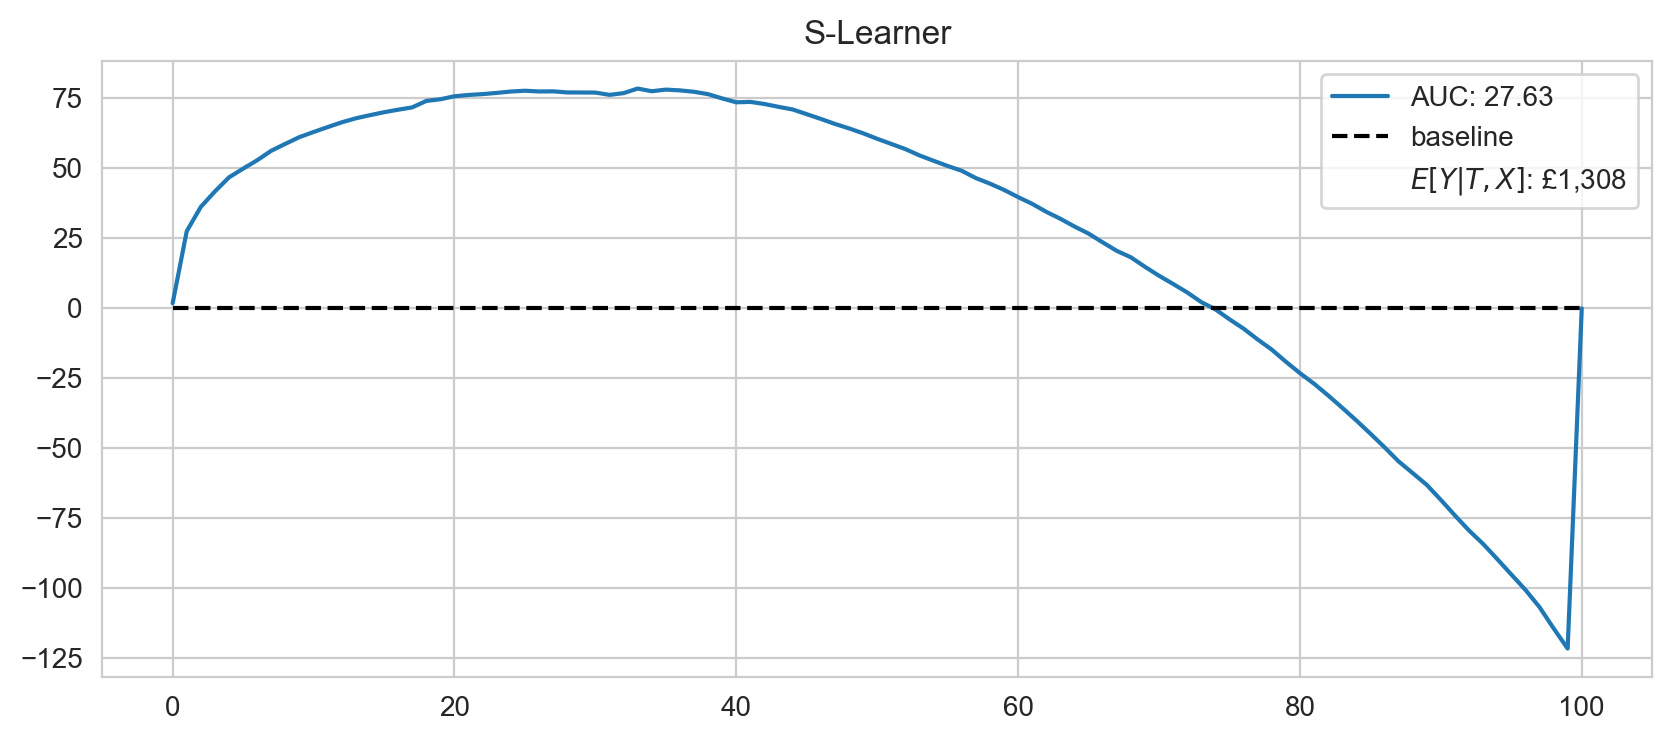

In [11]:
gain_curve_test = relative_cumulative_gain_curve(
    df=s_learner_cate_test, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)
auc = area_under_the_relative_cumulative_gain_curve(
    df=s_learner_cate_test, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)

plt.figure(figsize=(10, 4))
plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="baseline")
plt.plot([], [], ' ', label=f"$E[Y|T, X]$: £{s_learner_cate_test['cate'].mean():,.0f}")
plt.legend()
plt.title("S-Learner");

 * Oh dear, this doesn't look very good - while the overall CATE estimate looks reasonable and closely matches that obtained through using the propensity scores.
 * The AUC score is quite low, and we have a very weird shape to the cumulative gain curve, meaning that this model doesn't do a great job of ordering the customers.
 * Fortunately, this is only the first model we'll look at so we can see how the others will hopefully improve upon on the areas where this simple model falls down. 

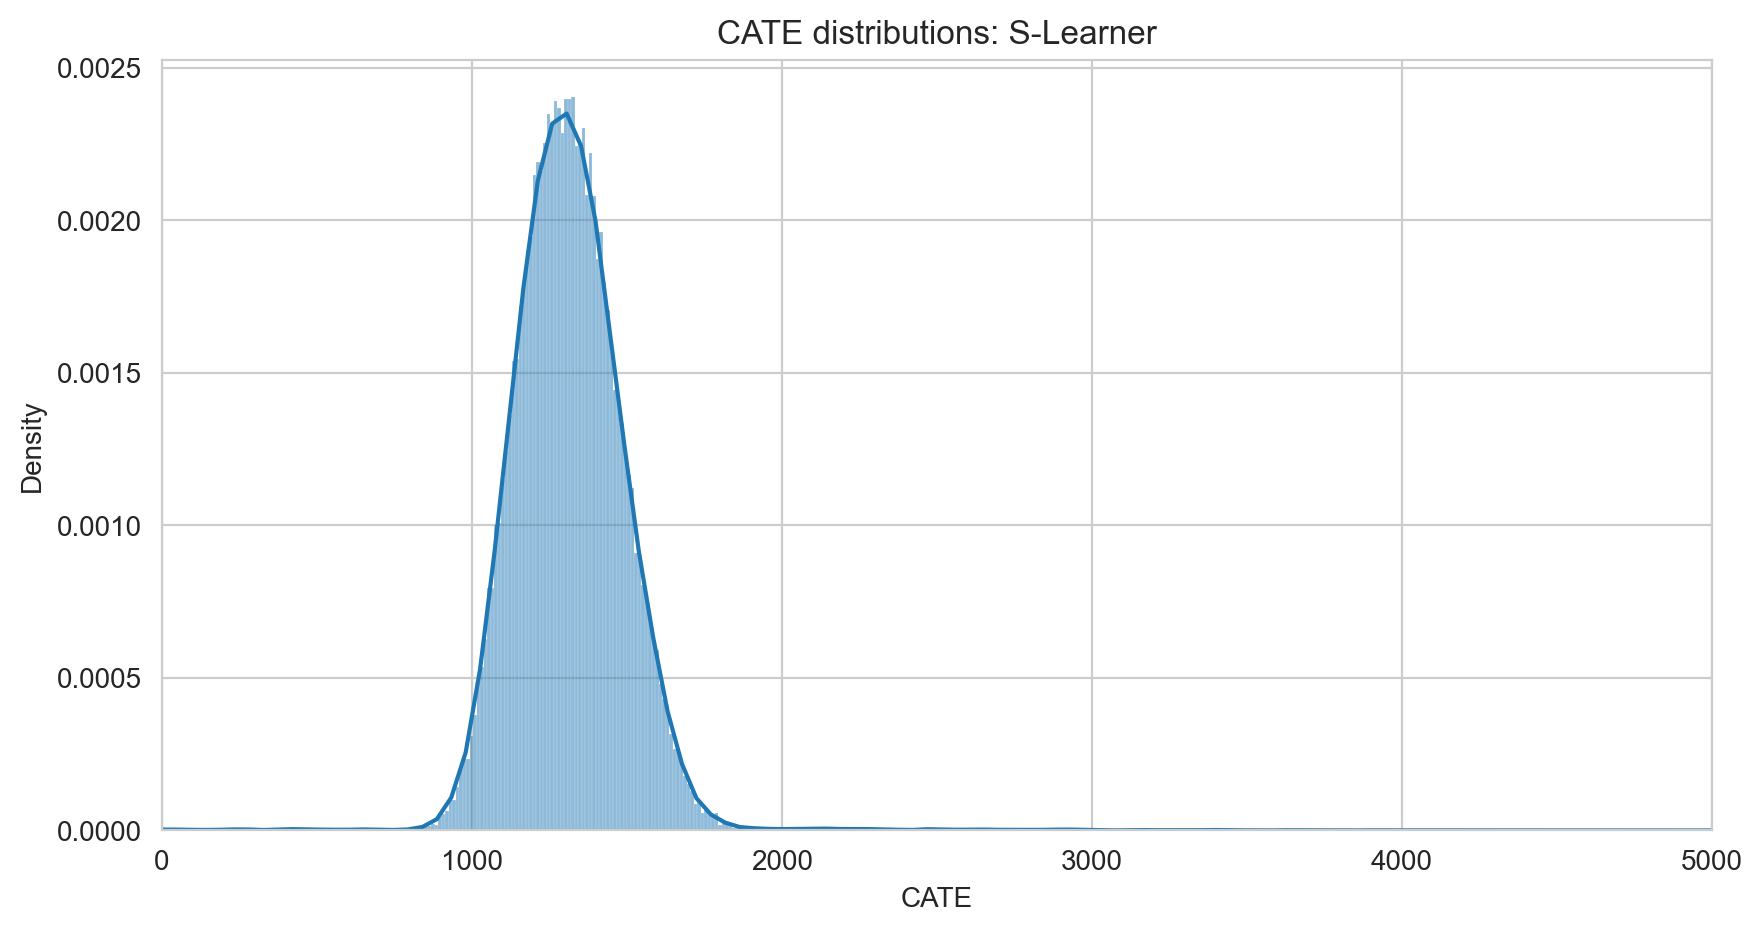

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(
    s_learner_cate_test, 
    x='cate', 
    kde=True, 
    stat='density', 
    common_norm=False,
    ax=ax
)
ax.set(
    title='CATE distributions: S-Learner',
    xlabel='CATE'
)
ax.set_xlim(0, 5000);

## T-Learner


 * Same as the S-Learner except this time we're fitting two models for the treated and untreated groups (ergo the **T** in T-Learner).
 * The difference in the predictions between treated and untreated, forms our conditional average treatment effect (CATE).


#### Pro's

 * Very simple, providing unbiased estimates
 * Works well when there's lots of data.


#### Con's

 * **Balanced data** - T-Learner's prefer balance between treated and untreated, otherwise the model trained on the smaller group may underfit, reducing performance.

 * **Not very data efficient** - each model is only trained on a subset of the data, thus, each model does not learn from the overall distribution of values.

 * **Independent models** - each model is trained independently, and thus subtracting the model's outputs may lead to incorrect treatment effects. This can arise from issues such as lack of calibration between models, some models being trained on smaller datasets (if one treatment has less data), thus to errors when the models’ outcomes are aggregated.

In [13]:
np.random.seed(123)

m0 = LGBMRegressor()
m1 = LGBMRegressor()

m0.fit(train_data.query(f"{T} == 0")[X], train_data.query(f"{T} == 0")[y])
m1.fit(train_data.query(f"{T} == 1")[X], train_data.query(f"{T} == 1")[y])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 146759, number of used features: 25
[LightGBM] [Info] Start training from score 88.249324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 153241, number of used features: 25
[LightGBM] [Info] Start training from score 1596.224063


LGBMRegressor()

In [14]:
t_learner_cate_test = test_data.assign(
    cate=m1.predict(test_data[X]) - m0.predict(test_data[X])
)

In [15]:
gain_curve_test = relative_cumulative_gain_curve(
    df=t_learner_cate_test, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)
auc = area_under_the_relative_cumulative_gain_curve(
    df=t_learner_cate_test, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)

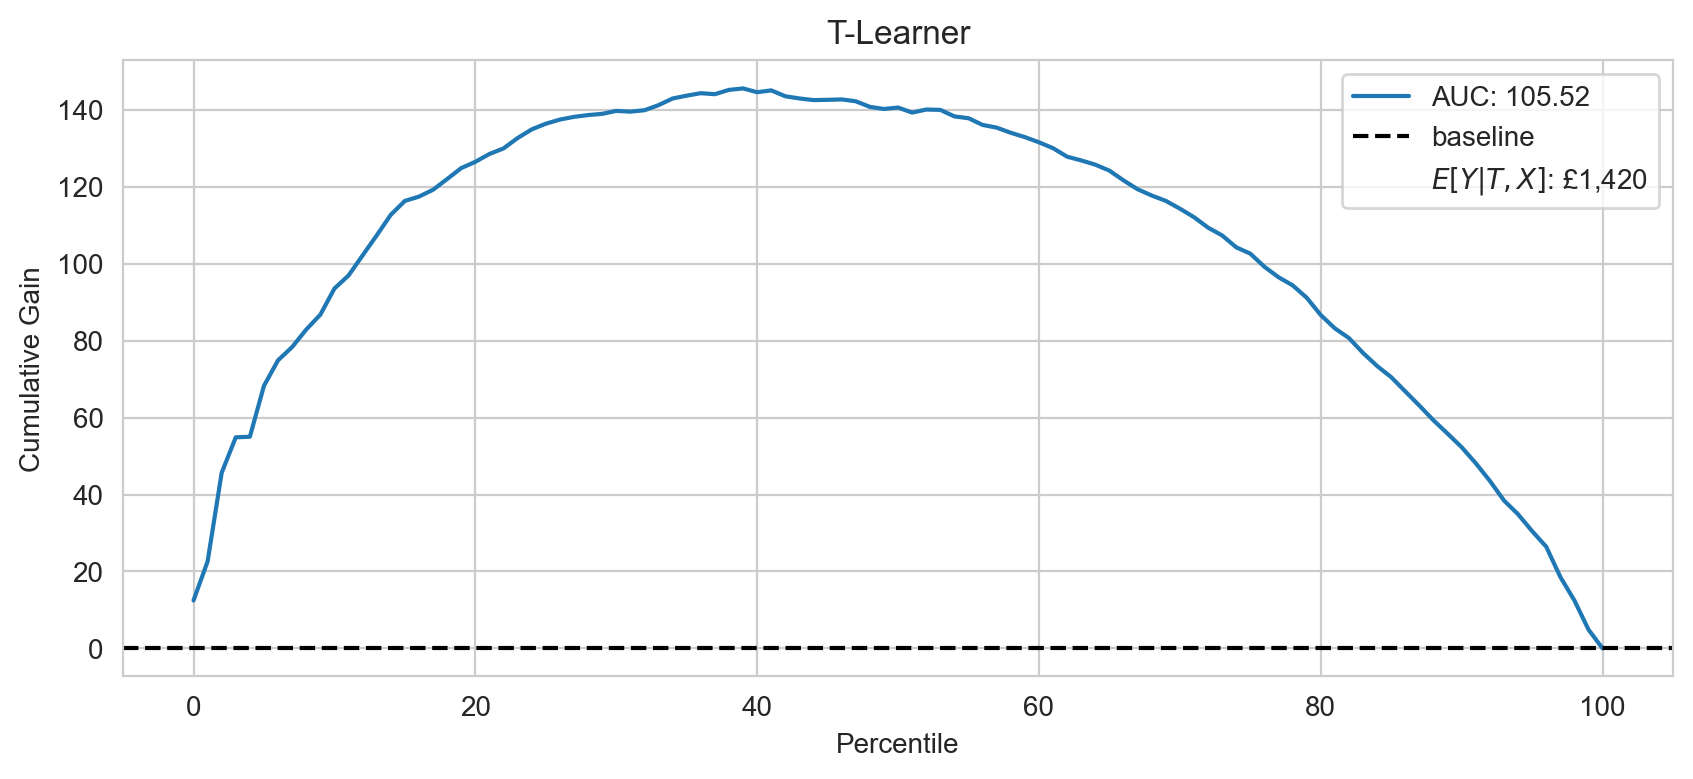

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
ax.axhline(0, 0, 100, linestyle="--", color="black", label="baseline")
ax.plot([], [], ' ', label=f"$E[Y|T, X]$: £{t_learner_cate_test['cate'].mean():,.0f}")

ax.set(
    title="T-Learner",
    xlabel="Percentile",
    ylabel="Cumulative Gain"
)
plt.legend();

 * Can see that this time round the model performs far better, with a much higher AUC at ~105 and all of the cumulative gain sits above zero (which it should!).
 * So we can see that this model does a far better of ordering the customer base (likely due to ~50/50 split of treated and control units) as well as giving us a reasonable CATE estimate.

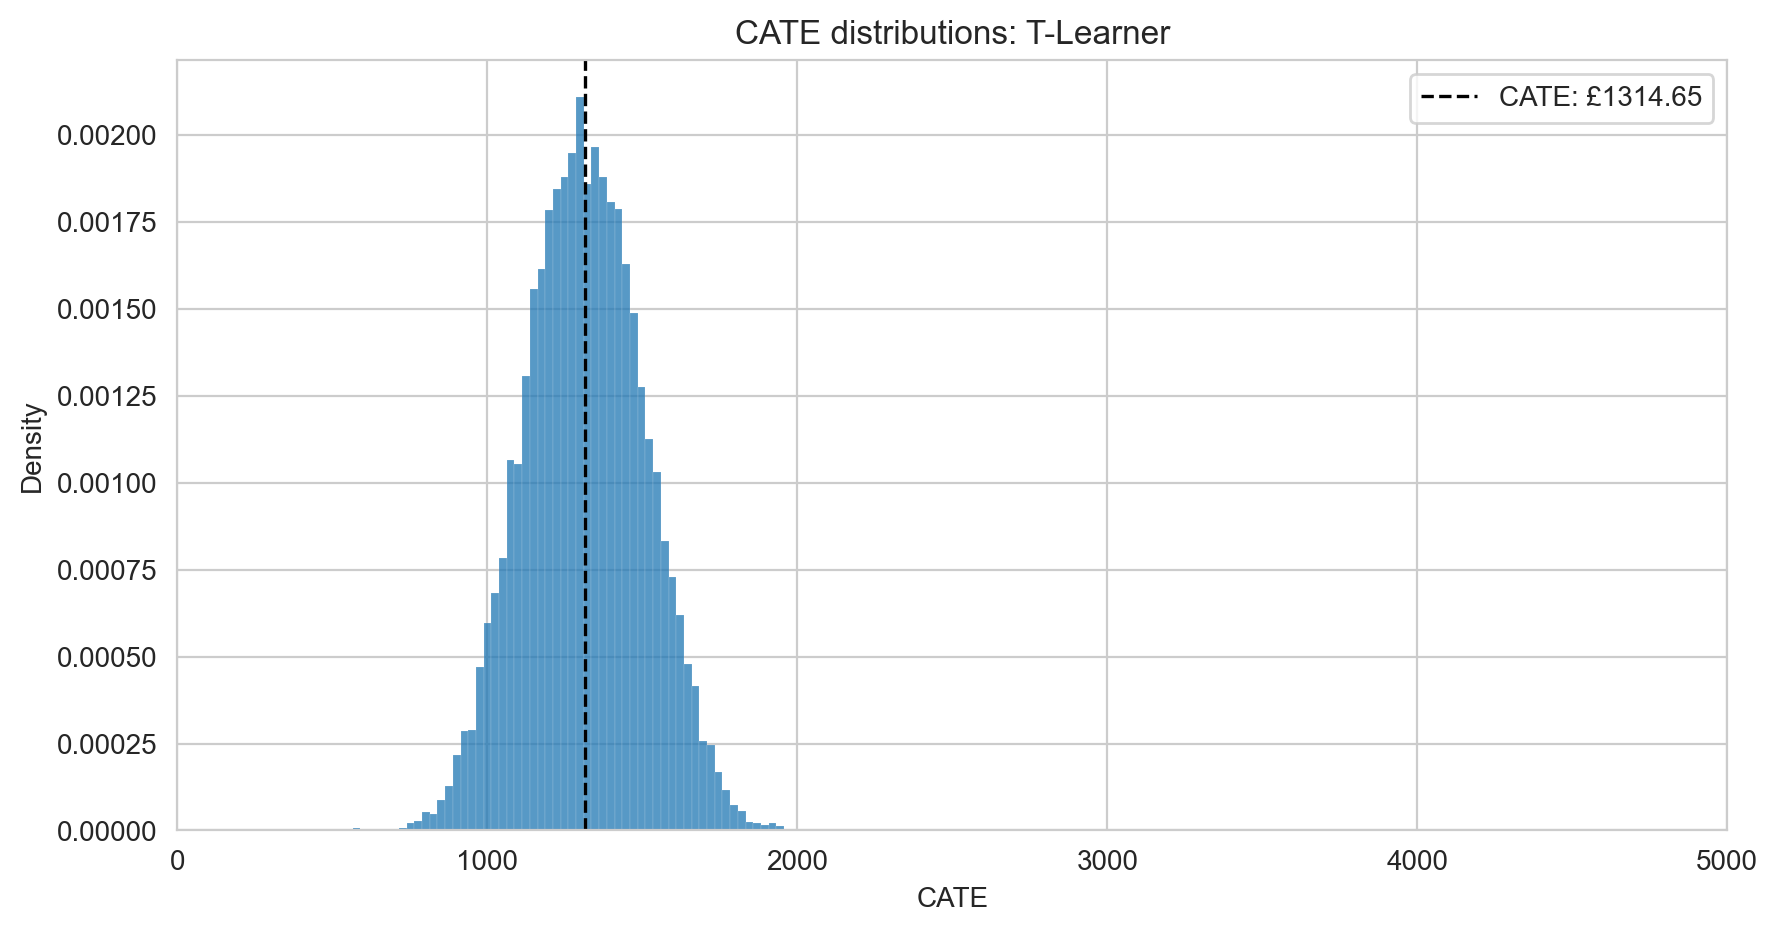

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

middle = t_learner_cate_test['cate'].median()

ax.axvline(middle, lw=1.2, ls='--', color='k', label=f"CATE: £{middle:.2f}")

sns.histplot(
    t_learner_cate_test, 
    x='cate', 
    kde=False, 
    stat='density', 
    common_norm=False,
    ax=ax
)
ax.set(
    title='CATE distributions: T-Learner',
    xlabel='CATE'
)
ax.set_xlim(0, 5000)
plt.legend();

## X-Learner

 * An extension of the T-learner, it is often used when there is an imbalance in the number of treated vs untreated samples (i.e. where we have **_far more treated samples_** (hint hint)). It constructs separate models for treatment and control groups and then uses those models to estimate treatment effects for each group.

#### Pro's

 * Tries to address the issue of regularisation bias by using a propensity score model to lower the importance of 
 trained on a small sample.

#### Con's

 * Same as the T-Learner (minus needing the balanced dataset).

In [18]:
np.random.seed(1)

mu_tau0 = LGBMRegressor(min_child_samples=25)
mu_tau1 = LGBMRegressor(min_child_samples=25)

In [19]:
# propensity score model
ps_model = LogisticRegression(penalty=None)
ps_model.fit(train_data[X], train_data[T])

LogisticRegression(penalty=None)

In [20]:
# first stage models
train_t0 = train_data.query(f"{T} == 0")
train_t1 = train_data.query(f"{T} == 1")

In [21]:
m0 = LGBMRegressor()
m1 = LGBMRegressor()

In [22]:
np.random.seed(123)

m0.fit(
    train_t0[X], 
    train_t0[y],
    sample_weight=1 / ps_model.predict_proba(train_t0[X])[:, 0]
)

m1.fit(
    train_t1[X], 
    train_t1[y],
    sample_weight=1 / ps_model.predict_proba(train_t1[X])[:, 1]
);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 146759, number of used features: 25
[LightGBM] [Info] Start training from score 93.794406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 153241, number of used features: 25
[LightGBM] [Info] Start training from score 1500.812055


In [23]:
np.random.seed(123)

# second stage
tau_hat_0 = m1.predict(train_t0[X]) - train_t0[y]
tau_hat_1 = train_t1[y] - m0.predict(train_t1[X])

m_tau_0 = LGBMRegressor()
m_tau_1 = LGBMRegressor()

m_tau_0.fit(train_t0[X], tau_hat_0)
m_tau_1.fit(train_t1[X], tau_hat_1);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 146759, number of used features: 25
[LightGBM] [Info] Start training from score 1314.596849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 153241, number of used features: 25
[LightGBM] [Info] Start training from score 1496.527628


In [24]:
# estimate the CATE
ps_test = ps_model.predict_proba(test_data[X])[:, 1]

x_learner_cate_test = test_data.assign(
    cate=(
        ps_test * m_tau_0.predict(test_data[X]) 
        + (1 - ps_test) * m_tau_1.predict(test_data[X])    
    )
)

In [25]:
gain_curve_test = relative_cumulative_gain_curve(
    df=x_learner_cate_test, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)
auc = area_under_the_relative_cumulative_gain_curve(
    df=x_learner_cate_test, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)

cate = x_learner_cate_test['cate'].mean()

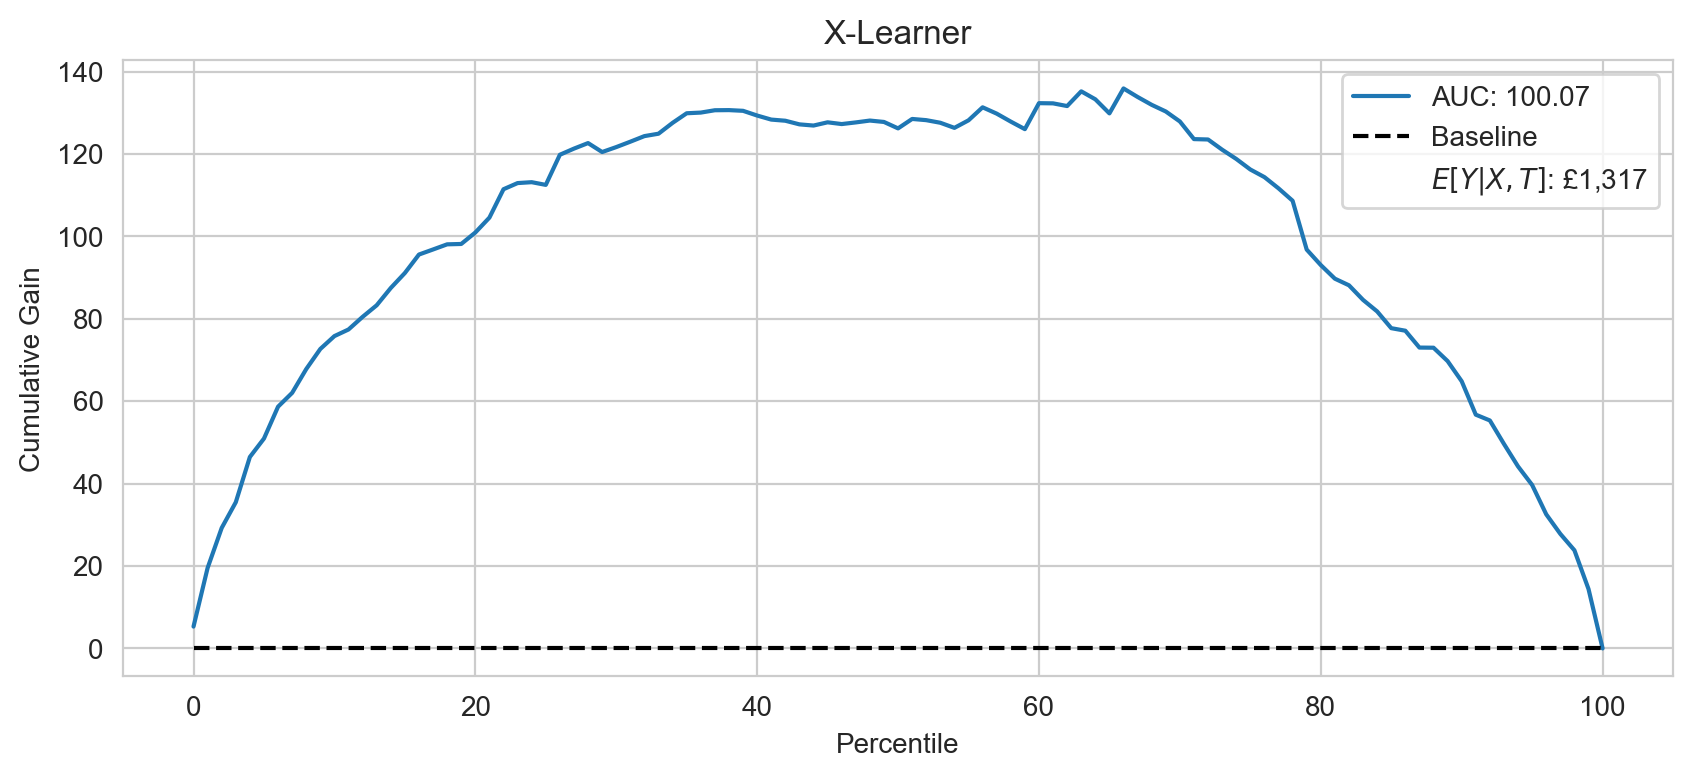

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
ax.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")
plt.plot([], [], ' ', label=f"$E[Y|X, T]$: £{cate:,.0f}")
plt.legend()
ax.set(
    title="X-Learner",
    xlabel="Percentile",
    ylabel="Cumulative Gain"
);

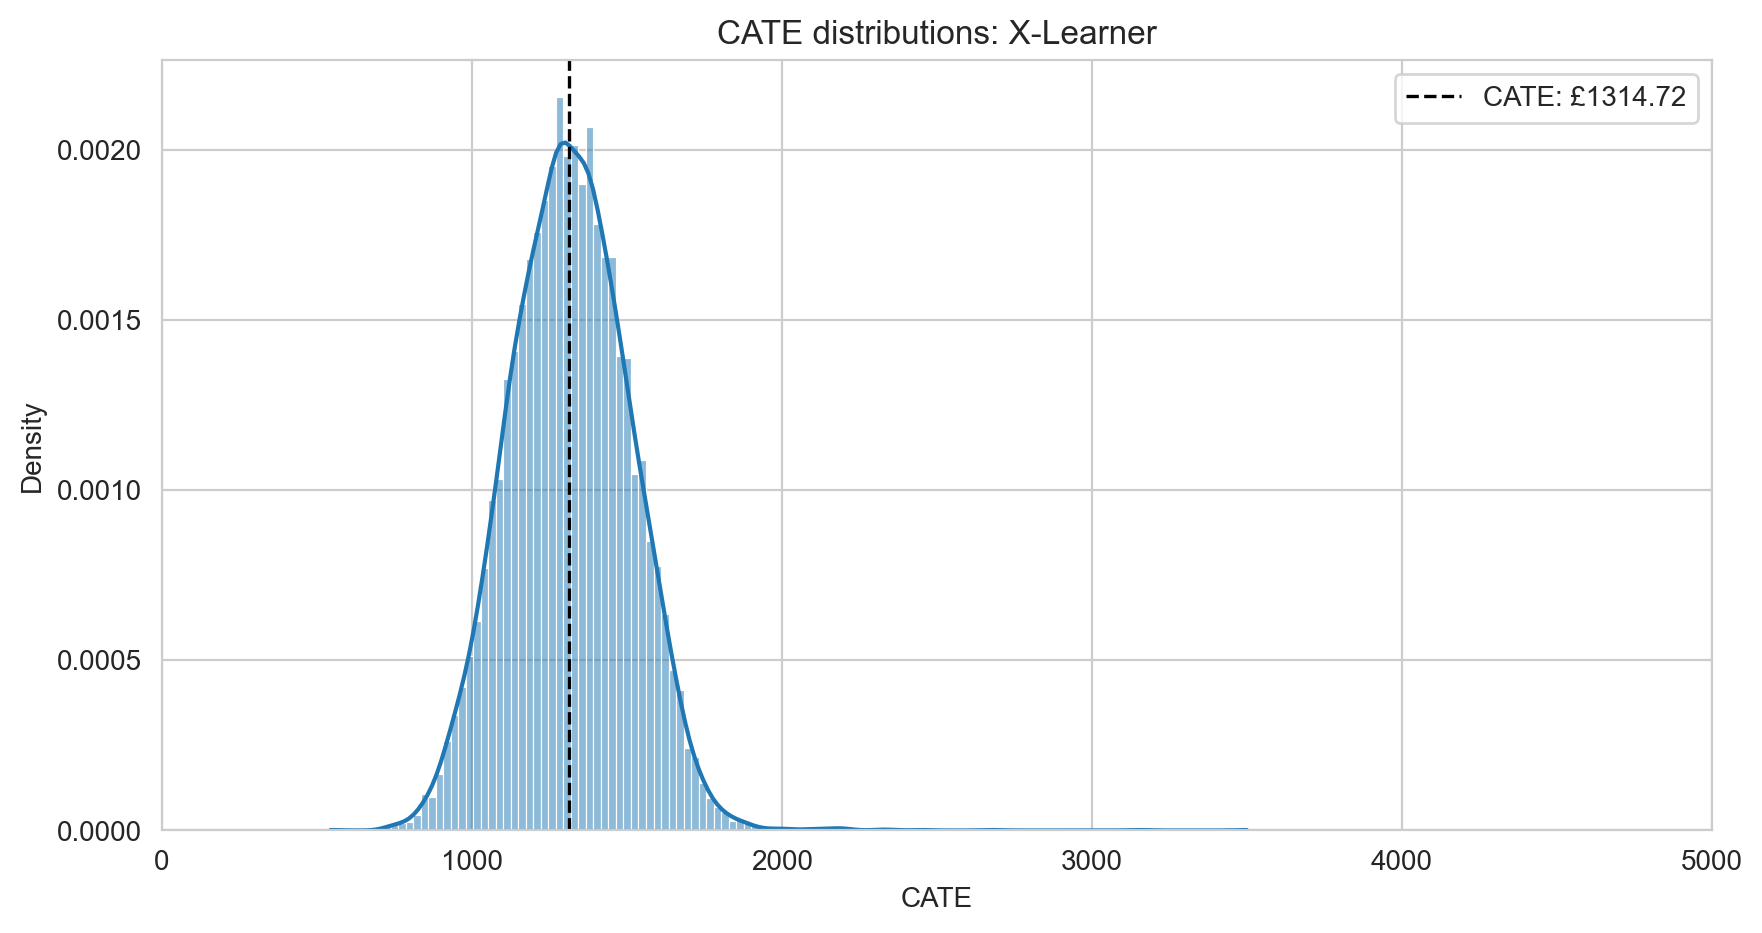

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

middle = x_learner_cate_test['cate'].median()

sns.histplot(
    x_learner_cate_test, 
    x='cate', 
    kde=True, 
    stat='density', 
    common_norm=False,
    ax=ax
)
ax.axvline(middle, lw=1.2, ls='--', color='k', label=f"CATE: £{middle:.2f}")
ax.set(
    title='CATE distributions: X-Learner',
    xlabel='CATE'
)
ax.set_xlim(0, 5000)
plt.legend();

## R-Learner (Doubly Robust ML)

 *  Last is double debiased ML, which uses FWL theorem, to use ML models to predict the treatment and outcome residuals, and then use this to get the ATE by regression the the treatment residuals on the outcome residuals.

#### Pro's

 * **Direct CATE Estimates** - directly outputs the CATE estimates on a per-user level.

#### Con's

 * **Overfitting** - can be prone to overfitting, to mitigate this we use K-Fold cross validation.

In [28]:
debias_model = LGBMRegressor()
denoise_model = LGBMRegressor()

In [29]:
K = 5

t_residual = train_data[T] - cross_val_predict(debias_model, train_data[X], train_data[T], cv=K)
y_residual = train_data[y] - cross_val_predict(denoise_model, train_data[X], train_data[y], cv=K)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 25
[LightGBM] [Info] Start training from score 0.510796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 25
[LightGBM] [Info] Start training from score 0.511096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [30]:
sm.OLS(y_residual, t_residual).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
mkt_email,1316.0046,4.712,279.289,0.000,1306.769,1325.240


In [31]:
ate = sm.OLS(y_residual, t_residual).fit().params.get("mkt_email")
print(f"ATE: £{ate:,.0f}")

ATE: £1,316


In [32]:
y_star = y_residual / t_residual
w = np.square(t_residual)

cate_model = LGBMRegressor()

cate_model.fit(
    train_data[X], 
    y_star, 
    sample_weight=w
)

test_r_learner_pred = (
    test_data
    .assign(
        cate=cate_model.predict(test_data[X])
    )
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 25
[LightGBM] [Info] Start training from score 1316.004563


In [33]:
gain_curve_test = relative_cumulative_gain_curve(
    df=test_r_learner_pred, 
    treatment=T, 
    outcome=y,
    prediction="cate"
)
auc = area_under_the_relative_cumulative_gain_curve(
    df=test_r_learner_pred, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)
cate = test_r_learner_pred['cate'].median()

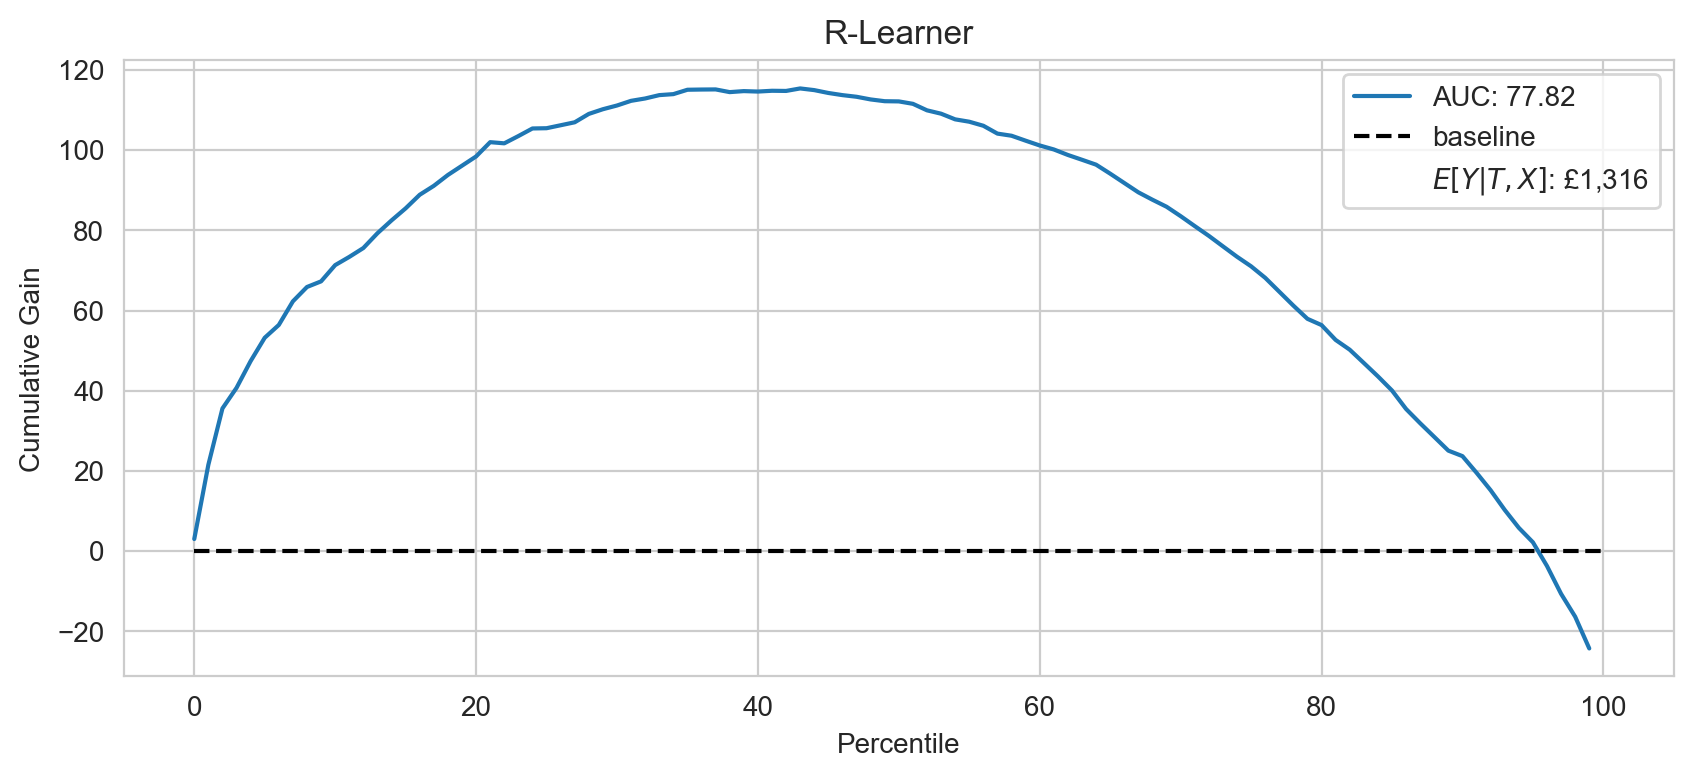

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(gain_curve_test[:-1], color="C0", label=f"AUC: {auc:.2f}")
ax.hlines(0, 0, 100, linestyle="--", color="black", label="baseline")
plt.plot([], [], ' ', label=f"$E[Y|T, X]$: £{cate:,.0f}")
ax.set(
    title="R-Learner",
    xlabel="Percentile",
    ylabel="Cumulative Gain"
)
plt.legend();

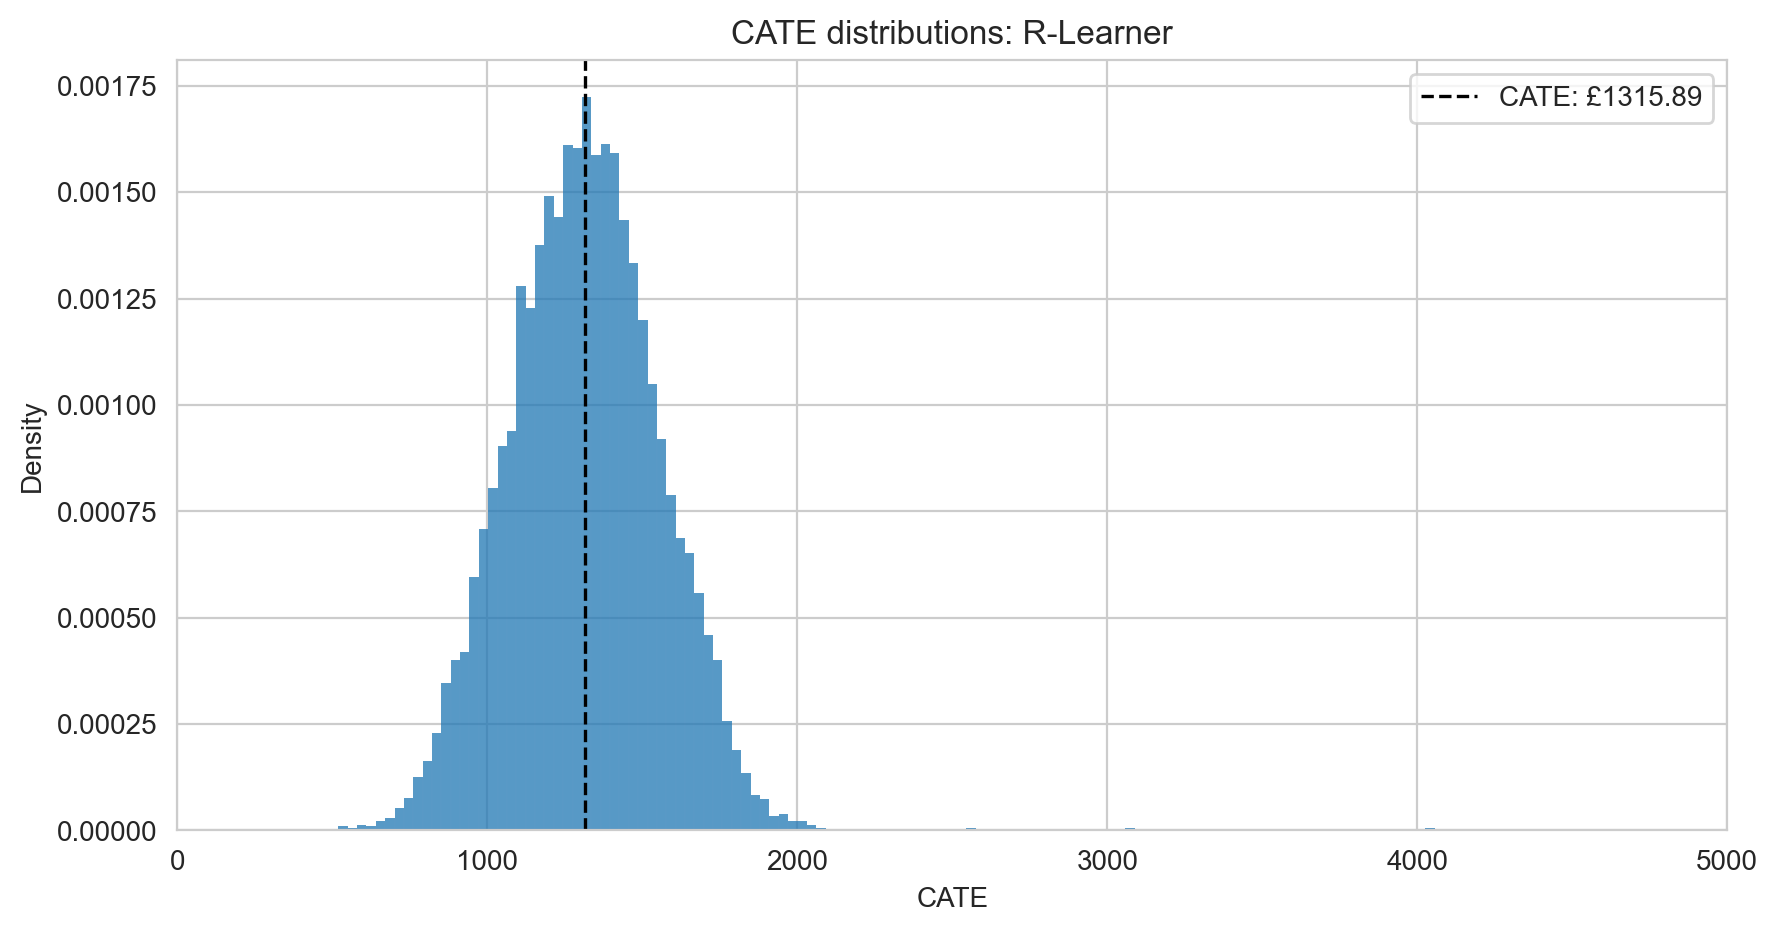

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

middle = test_r_learner_pred['cate'].median()

sns.histplot(
    test_r_learner_pred, 
    x='cate', 
    kde=False, 
    stat='density', 
    common_norm=False,
    ax=ax
)
ax.axvline(middle, lw=1.2, ls='--', color='k', label=f"CATE: £{cate:.2f}")
ax.set(
    title='CATE distributions: R-Learner',
    xlabel='CATE'
)
ax.set_xlim(0, 5000)
plt.legend();

## Z-Learner (Outcome Transformation)

 * Z-Learner is where we transform the current outcome variable $Y$ to make a *new* outcome variable $Z$ in order to predict the CATE.

 * This is done by dividing the outcome by a propensity score if they actually **_did_** receive the treatment, and get this, dividing the outcome by 1 minus the propensity score, and making it negative, if they **_did not_** receive the treatment.

 * The outcome transformation then converges to the overall ATE across the whole dataset and to the CATE on a subset of $X$.


$\Large
Z= \left\{\begin{matrix}
\frac{Y}{e(x)} & \text{if  } \;T=1 \\
-\frac{Y}{1-e(x)} &  \text{if } \; T=0\\
\end{matrix}\right. 
$

#### Pro's
 * Very simple, only requires one model to fit + predict
 * Works well then the number of treated units or treatment effect is very small.

#### Con's
 * **High Variance** - Outcome distribution can be very wide / heavy tailed, leading to CATE estimations with a high degree of noise.

 * **Long-Tailed Data** - Struggles on noisy or long-tailed distributions, again leading to predictions with high variance.

In [36]:
X_train_untreated = X_train.copy().drop(columns=[T])
X_test_untreated = X_test.copy().drop(columns=[T])

In [37]:
# compute propensity 
p_of_t = np.mean(X_train[T].to_numpy())
print(f"Propensity score for the treatment group: {p_of_t:,.4f}")

p_score = np.where(
    X_train[T] == 1, 
    p_of_t, 
    1 - p_of_t
)

# outcome transformation
treatment_train = X_train[T].to_numpy()

z_train = np.where(
    treatment_train == 1, 
    y_train, 
    -y_train
) / p_score

Propensity score for the treatment group: 0.5103


In [38]:
# Train Z-Learner model
z_learner = LGBMRegressor()
z_learner.fit(
    X_train_untreated, 
    z_train
);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 248000, number of used features: 25
[LightGBM] [Info] Start training from score 1505.199442


In [39]:
# Estimate CATE using the difference in predictions
z_learner_cate_test = X_test.assign(
    cate=z_learner.predict(X_test_untreated),
    next_mnth_pv=y_test
)

In [40]:
gain_curve_test = relative_cumulative_gain_curve(
    df=z_learner_cate_test, 
    treatment=T, 
    outcome=y,
    prediction="cate"
)
auc = area_under_the_relative_cumulative_gain_curve(
    df=z_learner_cate_test, 
    treatment=T, 
    outcome=y, 
    prediction="cate"
)
cate = z_learner_cate_test['cate'].median()

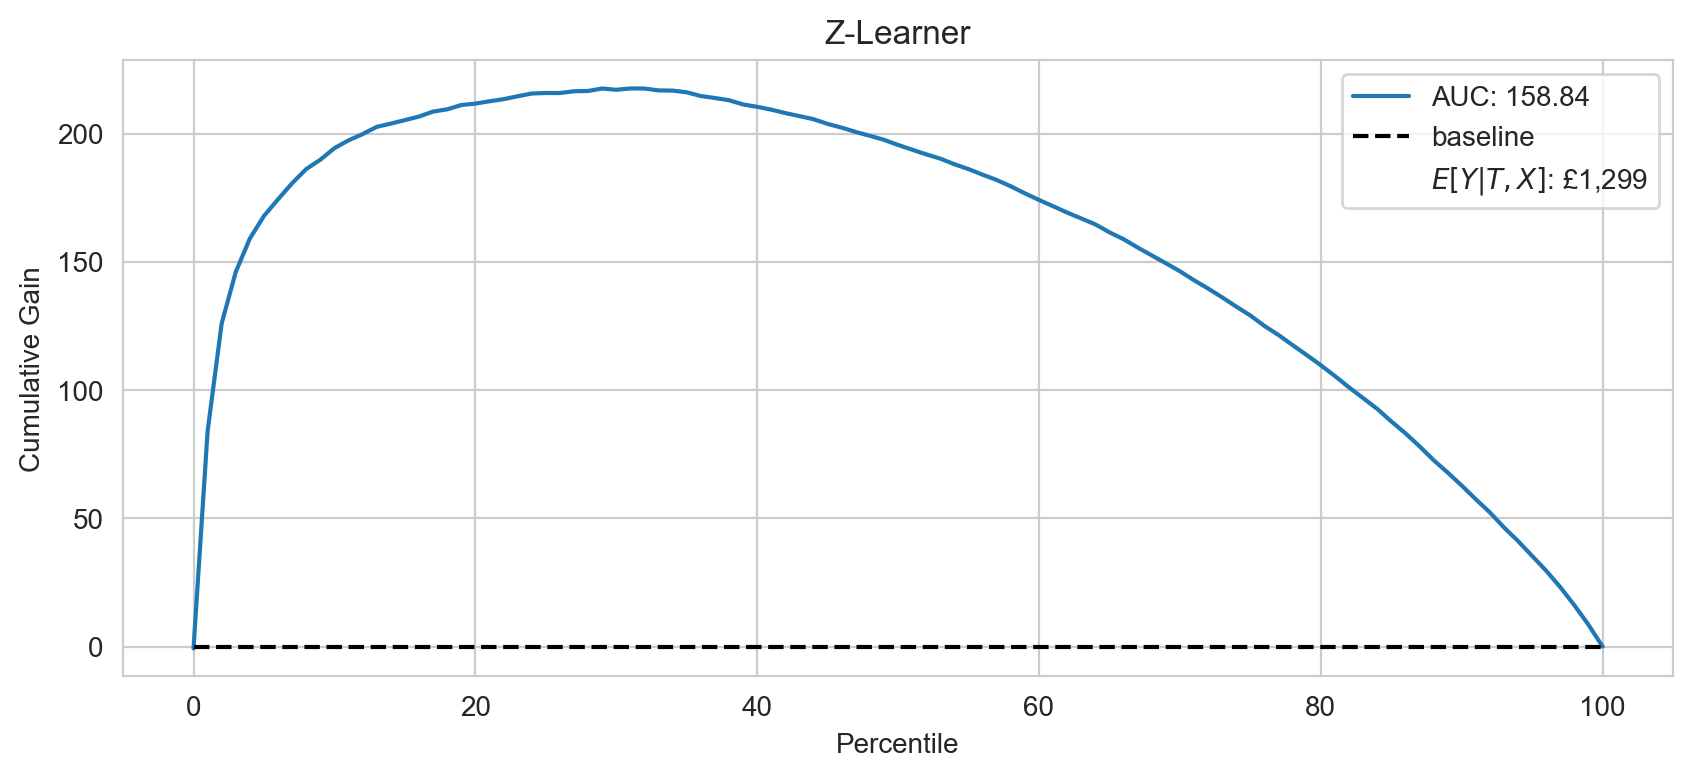

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
ax.hlines(0, 0, 100, linestyle="--", color="black", label="baseline")
plt.plot([], [], ' ', label=f"$E[Y|T, X]$: £{cate:,.0f}")
ax.set(
    title="Z-Learner",
    xlabel="Percentile",
    ylabel="Cumulative Gain"
)
plt.legend();

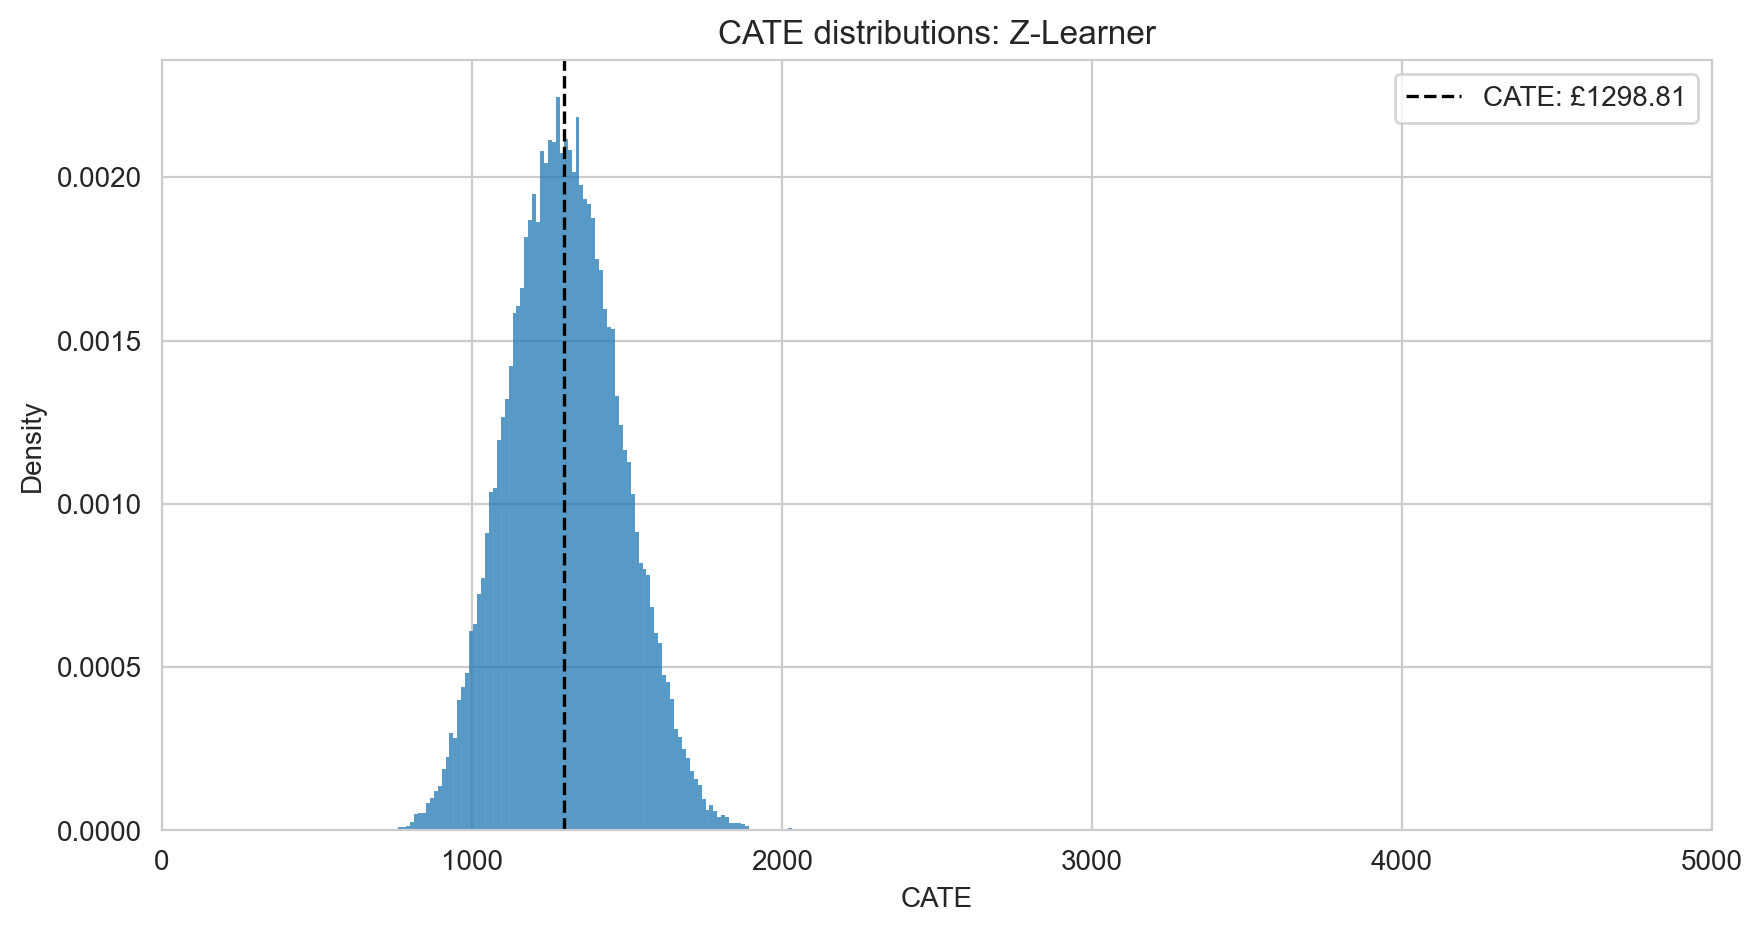

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

middle = z_learner_cate_test['cate'].median()

sns.histplot(
    z_learner_cate_test, 
    x='cate', 
    kde=False, 
    stat='density', 
    common_norm=False,
    ax=ax
)
ax.axvline(middle, lw=1.2, ls='--', color='k', label=f"CATE: £{middle:.2f}")
ax.set(
    title='CATE distributions: Z-Learner',
    xlabel='CATE'
)
ax.set_xlim(0, 5000)
plt.legend();

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Oct 13 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.12.3

numpy      : 1.26.4
sys        : 3.11.9 (main, Apr 19 2024, 11:43:47) [Clang 14.0.6 ]
sklearn    : 1.5.2
lightgbm   : 4.5.0
pandas     : 2.2.3
seaborn    : 0.13.2
matplotlib : 3.9.2
statsmodels: 0.14.3

Watermark: 2.5.0

